
<div style="font-family:'JetBrains Mono', monospace; text-align:center; color:#A7C080;">

# Toronto Urban Heat & Tree Canopy Explorer
</div>

In [ ]:
# STEP 1:Shapefiles
import geopandas as gpd
import matplotlib.pyplot as plt

print("=== STEP 1: Loading and Checking Shapefiles ===")

# Neighborhood boundaries
neighborhoods = gpd.read_file("Neighbourhoods.shp")
print(f"Neighbourhoods: {len(neighborhoods)} areas loaded")

# Toronto boundary  
boundary = gpd.read_file("Boundary.shp")
print(f"Boundary: {len(boundary)} features loaded")

# Green spaces
greenspaces = gpd.read_file("Green Spaces.shp")
print(f"Green Spaces: {len(greenspaces)} features loaded")

# Treed areas
treed_areas = gpd.read_file("TOPO_TREED_AREA_WGS84.shp")
print(f"Treed Areas: {len(treed_areas)} features loaded")

# Water bodies
water = gpd.read_file("Water.shp")
print(f"Water: {len(water)} features loaded")

# Check coordinate systems
print("\nCoordinate Systems:")
print(f"Neighbourhoods: {neighborhoods.crs}")
print(f"Green Spaces: {greenspaces.crs}")
print(f"Treed Areas: {treed_areas.crs}")
print(f"Water: {water.crs}")
# STEP 4: Convert All Shapefiles to Common CRS
print("=== STEP 4: Converting to Common Coordinate System ===")

# Convert each shapefile
target_crs = 'EPSG:32617'  # This is the LST data's CRS
neighborhoods_utm = neighborhoods.to_crs(target_crs)
greenspaces_utm = greenspaces.to_crs(target_crs)
treed_areas_utm = treed_areas.to_crs(target_crs)
water_utm = water.to_crs(target_crs)

# Verifying conversions
print(f"\nCurrent CRS:")
print(f"Neighbourhoods: {neighborhoods_utm.crs}")
print(f"Green Spaces: {greenspaces_utm.crs}")
print(f"Treed Areas: {treed_areas_utm.crs}")
print(f"Water: {water_utm.crs}")

=== STEP 1: Loading and Checking Shapefiles ===
Neighbourhoods: 140 areas loaded
Boundary: 5 features loaded
Green Spaces: 3320 features loaded
Treed Areas: 45638 features loaded
Water: 1 features loaded

Coordinate Systems:
Neighbourhoods: EPSG:26917
Green Spaces: EPSG:4326
Treed Areas: EPSG:4326
Water: EPSG:26917
=== STEP 4: Converting to Common Coordinate System ===

Current CRS:
Neighbourhoods: EPSG:32617
Green Spaces: EPSG:32617
Treed Areas: EPSG:32617
Water: EPSG:32617


In [4]:
# STEP 2:Landsat LST Data
import rasterio
import numpy as np
from rasterio.plot import show

try:
    with rasterio.open("raster/LANDSAT.TIF") as src:
        thermal_data = src.read(1)
        profile = src.profile
        print(f"  Shape: {thermal_data.shape}")
        print(f"  Data type: {thermal_data.dtype}")
        print(f"  CRS: {src.crs}")
        print(f"  Bounds: {src.bounds}")
        
        # basic stats
        print(f"  Min value: {thermal_data.min():.2f}")
        print(f"  Max value: {thermal_data.max():.2f}")
        print(f"  Mean value: {thermal_data.mean():.2f}")
        
except Exception as e:
    print(f"Error loading thermal band: {e}")

  Shape: (7751, 7651)
  Data type: uint16
  CRS: EPSG:32617
  Bounds: BoundingBox(left=581385.0, bottom=4667385.0, right=810915.0, top=4899915.0)
  Min value: 0.00
  Max value: 52645.00
  Mean value: 29315.16


In [ ]:
# STEP 3: Temperature conversions
print("=== STEP 3: Converting to Land Surface Temperature ===")
# Convert raw thermal data to Celsius using Landsat scaling factors
# ST_B10 to temperature conversion
thermal_data_clean = thermal_data.copy()

# Apply scaling to get Kelvin, then convert to Celsius
lst_kelvin = (thermal_data_clean * 0.00341802) + 149.0
lst_celsius = lst_kelvin - 273.15

print(f"  LST range: {np.nanmin(lst_celsius):.1f}°C to {np.nanmax(lst_celsius):.1f}°C")
print(f"  Mean LST: {np.nanmean(lst_celsius):.1f}°C")

=== STEP 3: Converting to Land Surface Temperature ===
  LST range: -124.1°C to 55.8°C
  Mean LST: -24.0°C


In [9]:
# STEP 4: Raster Clipping
from rasterio.mask import mask
import json
toronto_boundary = neighborhoods_utm.union_all()
toronto_boundary_gdf = gpd.GeoDataFrame(geometry=[toronto_boundary], crs=target_crs)
print(f"Toronto boundary bounds: {toronto_boundary.bounds}") #verifying

# Get LST bounds from the source file
with rasterio.open("raster/LANDSAT.TIF") as src:
    lst_bounds = src.bounds
    print(f"LST data bounds: {lst_bounds}")

# Check if they overlap
from shapely.geometry import box
lst_bounds_box = box(lst_bounds.left, lst_bounds.bottom, lst_bounds.right, lst_bounds.top)
overlaps = toronto_boundary.intersects(lst_bounds_box)
print(f"Do they overlap? {overlaps}")

# for rasterio mask
def get_features(gdf):
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

toronto_geojson = get_features(toronto_boundary_gdf)

# Clip the raster
try:
    with rasterio.open("raster/LANDSAT.TIF") as src:
        out_image, out_transform = mask(src, toronto_geojson, crop=True, filled=False)
        out_meta = src.meta.copy()
        
        # Update metadata
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        
        # Save clipped LST
        with rasterio.open("toronto_lst_clipped.tif", "w", **out_meta) as dest:
            dest.write(out_image)
        
        print(f"  Original size: {src.shape}")
        print(f"  Clipped size: {out_image.shape}")
        
except Exception as e:
    print(f"Error clipping LST: {e}")
    import traceback
    traceback.print_exc()

Toronto boundary bounds: (609557.0019991391, 4826366.461218282, 651631.1118988061, 4857444.9965185635)
LST data bounds: BoundingBox(left=581385.0, bottom=4667385.0, right=810915.0, top=4899915.0)
Do they overlap? True
  Original size: (7751, 7651)
  Clipped size: (1, 1037, 1403)


In [ ]:
# STEP 5: Getting rid of useless raster vales

with rasterio.open("toronto_lst_clipped.tif") as src:
    clipped_data = src.read(1)
    
    # Filter out extreme values (keep only reasonable range for LST)
    reasonable_min = 10000
    reasonable_max = 50000
    
    # Create a mask for reasonable values
    mask = (clipped_data >= reasonable_min) & (clipped_data <= reasonable_max)
    
    # Apply conversion only to reasonable values, set others to NaN
    lst_celsius_clean = np.full_like(clipped_data, np.nan, dtype=np.float32)
    lst_celsius_clean[mask] = ((clipped_data[mask] * 0.00341802) + 149.0) - 273.15
    
    print(f"Clean temperature range: {np.nanmin(lst_celsius_clean):.1f}°C to {np.nanmax(lst_celsius_clean):.1f}°C")
    print(f"Mean temperature: {np.nanmean(lst_celsius_clean):.1f}°C")
    print(f"Percentage of reasonable pixels: {np.sum(mask) / mask.size * 100:.1f}%")
    
    # Save the clean temperature data
    clean_profile = src.profile.copy()
    clean_profile.update({
        'dtype': rasterio.float32,
        'nodata': np.nan
    })
    
    with rasterio.open("toronto_lst_temperature_clean.tif", "w", **clean_profile) as dst:
        dst.write(lst_celsius_clean.astype(np.float32), 1)

Clean temperature range: 20.5°C to 42.7°C
Mean temperature: 30.5°C
Percentage of reasonable pixels: 34.1%
Clean temperature data saved as 'toronto_lst_temperature_clean.tif'


In [ ]:
# STEP 6: Zonal Statistics
from rasterstats import zonal_stats

stats = zonal_stats(
    neighborhoods_utm,
    "toronto_lst_temperature_clean.tif",
    stats=['mean', 'median', 'std', 'min', 'max', 'count'],
    nodata=np.nan
)
# Adding the statistics to the neighborhoods dataframe
neighborhoods_with_lst = neighborhoods_utm.copy()

for i, stat in enumerate(stats):
    neighborhoods_with_lst.loc[i, 'lst_mean'] = stat['mean']
    neighborhoods_with_lst.loc[i, 'lst_median'] = stat['median'] 
    neighborhoods_with_lst.loc[i, 'lst_std'] = stat['std']
    neighborhoods_with_lst.loc[i, 'lst_min'] = stat['min']
    neighborhoods_with_lst.loc[i, 'lst_max'] = stat['max']
    neighborhoods_with_lst.loc[i, 'pixel_count'] = stat['count']

# Verifyin
print(f"\nOverall LST range: {neighborhoods_with_lst['lst_mean'].min():.1f}°C to {neighborhoods_with_lst['lst_mean'].max():.1f}°C")
print(f"Average neighborhood LST: {neighborhoods_with_lst['lst_mean'].mean():.1f}°C")

Zonal stats calculated for 140 neighborhoods!!!

Overall LST range: 26.9°C to 33.9°C
Average neighborhood LST: 30.8°C


In [ ]:
# STEP 7: Vegetation Coverage
def calculate_vegetation_coverage(neighborhoods_gdf, greenspaces_gdf, treed_areas_gdf):
    """Calculate total vegetation coverage percentage for each neighborhood"""
    
    vegetation_stats = []
    
    for idx, neighborhood in neighborhoods_gdf.iterrows():
        neighborhood_area = neighborhood.geometry.area
        
        # greenspace areas
        greenspace_intersection = greenspaces_gdf.geometry.intersection(neighborhood.geometry)
        greenspace_area = greenspace_intersection.area.sum()
        
        # treed areas
        treed_intersection = treed_areas_gdf.geometry.intersection(neighborhood.geometry)
        treed_area = treed_intersection.area.sum()
        
        # Total vegetation area (sum of both)
        total_vegetation_area = greenspace_area + treed_area
        
        # percentage coverage
        vegetation_pct = (total_vegetation_area / neighborhood_area) * 100
        
        vegetation_stats.append({
            'vegetation_pct': vegetation_pct,
            'greenspace_pct': (greenspace_area / neighborhood_area) * 100,
            'treed_area_pct': (treed_area / neighborhood_area) * 100
        })
    
    return vegetation_stats

vegetation_stats = calculate_vegetation_coverage(neighborhoods_with_lst, greenspaces_utm, treed_areas_utm)

# Adding vegetation data to the dataframe
neighborhoods_with_vegetation = neighborhoods_with_lst.copy()

for i, stats in enumerate(vegetation_stats):
    neighborhoods_with_vegetation.loc[i, 'vegetation_pct'] = stats['vegetation_pct']
    neighborhoods_with_vegetation.loc[i, 'greenspace_pct'] = stats['greenspace_pct']
    neighborhoods_with_vegetation.loc[i, 'treed_area_pct'] = stats['treed_area_pct']

print(f"Vegetation range: {neighborhoods_with_vegetation['vegetation_pct'].min():.1f}% to {neighborhoods_with_vegetation['vegetation_pct'].max():.1f}%")
print(f"Average vegetation: {neighborhoods_with_vegetation['vegetation_pct'].mean():.1f}%")

Calculating vegetation coverage...
Vegetation range: 2.1% to 89.8%
Average vegetation: 21.1%


In [14]:
# STEP 8: Create Final Dataset for D3 Visualization
#This cell is only for exporting data for d3.js
import pandas as pd
from scipy.stats import pearsonr

# Calculate correlation between temperature and vegetation
correlation, p_value = pearsonr(
    neighborhoods_with_vegetation['lst_mean'], 
    neighborhoods_with_vegetation['vegetation_pct']
)

print(f"Correlation between temperature and vegetation: {correlation:.3f}")
print(f"P-value: {p_value:.4f}")

# CALCULATE COOLING SCORE
neighborhoods_with_vegetation['cooling_score'] = (
    neighborhoods_with_vegetation['vegetation_pct'] * 0.6 +           # Vegetation component (60%)
    (100 - neighborhoods_with_vegetation['lst_mean'] * 3) * 0.4      # Temperature component (40%)
)

# Normalize cooling score to 0-100 range
cooling_min = neighborhoods_with_vegetation['cooling_score'].min()
cooling_max = neighborhoods_with_vegetation['cooling_score'].max()
neighborhoods_with_vegetation['cooling_score'] = (
    (neighborhoods_with_vegetation['cooling_score'] - cooling_min) / 
    (cooling_max - cooling_min) * 100
)

print(f"Cooling score range: {neighborhoods_with_vegetation['cooling_score'].min():.1f} to {neighborhoods_with_vegetation['cooling_score'].max():.1f}")
print(f"Average cooling score: {neighborhoods_with_vegetation['cooling_score'].mean():.1f}")

# final dataset with only the fields needed for D3
final_data = neighborhoods_with_vegetation[[
    'HOOD', 'geometry', 'lst_mean', 'vegetation_pct', 'cooling_score'
]].copy()

final_data = final_data.rename(columns={
    'vegetation_pct': 'greenspace_pct'  # I wrote the D3 script with this field name
})

# Round values for cleaner display
final_data['lst_mean'] = final_data['lst_mean'].round(1)
final_data['greenspace_pct'] = final_data['greenspace_pct'].round(1)
final_data['cooling_score'] = final_data['cooling_score'].round(1)

print(f"Fields for D3: {list(final_data.columns)}")
print(f"Temperature range: {final_data['lst_mean'].min():.1f}°C to {final_data['lst_mean'].max():.1f}°C")
print(f"Vegetation range: {final_data['greenspace_pct'].min():.1f}% to {final_data['greenspace_pct'].max():.1f}%")
print(f"Cooling score range: {final_data['cooling_score'].min():.1f} to {final_data['cooling_score'].max():.1f}")

# Export as GeoJSON for the map
final_data.to_file("toronto_heat_canopy_final.geojson", driver='GeoJSON')

# Export as CSV for the scatter plot (without geometry)
scatter_data = final_data.drop('geometry', axis=1)
scatter_data.to_csv("scatter_data.csv", index=False)

# simple summary file
summary = {
    'total_neighborhoods': len(final_data),
    'avg_temperature': final_data['lst_mean'].mean(),
    'avg_vegetation': final_data['greenspace_pct'].mean(),
    'correlation': correlation,
    'temperature_range': f"{final_data['lst_mean'].min():.1f}°C - {final_data['lst_mean'].max():.1f}°C",
    'vegetation_range': f"{final_data['greenspace_pct'].min():.1f}% - {final_data['greenspace_pct'].max():.1f}%"
}

print("\n=== SUMMARY ===")
for key, value in summary.items():
    print(f"{key}: {value}")
    
print("1. toronto_heat_canopy_final.geojson - For the map")
print("2. scatter_data.csv - For the scatter plot")

Correlation between temperature and vegetation: -0.652
P-value: 0.0000
Cooling score range: 0.0 to 100.0
Average cooling score: 25.5
Fields for D3: ['HOOD', 'geometry', 'lst_mean', 'greenspace_pct', 'cooling_score']
Temperature range: 26.9°C to 33.9°C
Vegetation range: 2.1% to 89.8%
Cooling score range: 0.0 to 100.0

=== SUMMARY ===
total_neighborhoods: 140
avg_temperature: 30.754285714285718
avg_vegetation: 21.108571428571427
correlation: -0.6518134817050799
temperature_range: 26.9°C - 33.9°C
vegetation_range: 2.1% - 89.8%
1. toronto_heat_canopy_final.geojson - For the map
2. scatter_data.csv - For the scatter plot


=== STEP 12: Final Data Visualization ===


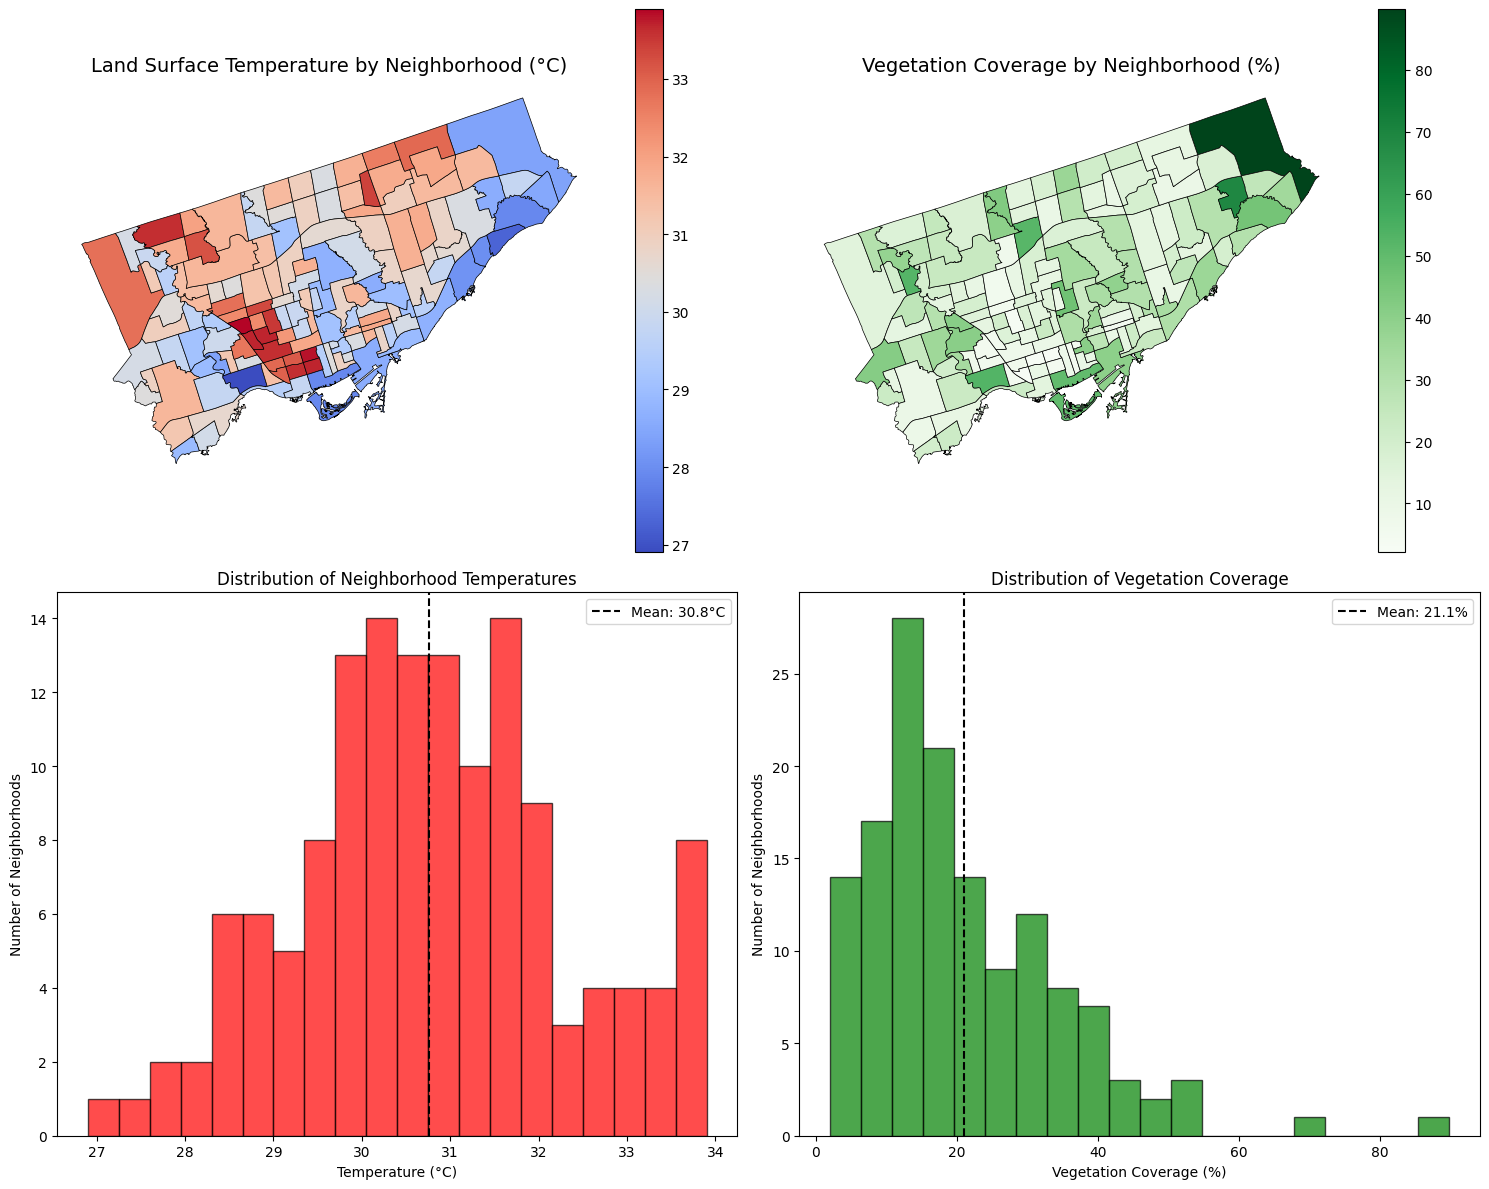

In [ ]:
# STEP 9: Visualization
import matplotlib.pyplot as plt
import seaborn as sns

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Temperature Map
final_data.plot(column='lst_mean', ax=ax1, cmap='coolwarm', legend=True, 
                edgecolor='black', linewidth=0.5)
ax1.set_title('Land Surface Temperature by Neighborhood (°C)', fontsize=14)
ax1.set_axis_off()

# 2. Vegetation Map
final_data.plot(column='greenspace_pct', ax=ax2, cmap='Greens', legend=True,
                edgecolor='black', linewidth=0.5)
ax2.set_title('Vegetation Coverage by Neighborhood (%)', fontsize=14)
ax2.set_axis_off()

# 3. Temperature Distribution
ax3.hist(final_data['lst_mean'], bins=20, color='red', alpha=0.7, edgecolor='black')
ax3.axvline(final_data['lst_mean'].mean(), color='black', linestyle='--', 
           label=f'Mean: {final_data["lst_mean"].mean():.1f}°C')
ax3.set_xlabel('Temperature (°C)')
ax3.set_ylabel('Number of Neighborhoods')
ax3.set_title('Distribution of Neighborhood Temperatures')
ax3.legend()

# 4. Vegetation Distribution
ax4.hist(final_data['greenspace_pct'], bins=20, color='green', alpha=0.7, edgecolor='black')
ax4.axvline(final_data['greenspace_pct'].mean(), color='black', linestyle='--',
           label=f'Mean: {final_data["greenspace_pct"].mean():.1f}%')
ax4.set_xlabel('Vegetation Coverage (%)')
ax4.set_ylabel('Number of Neighborhoods')
ax4.set_title('Distribution of Vegetation Coverage')
ax4.legend()

plt.tight_layout()
plt.show()

=== COMPREHENSIVE DATA VISUALIZATION - LIGHT THEME ===


C:\Users\snes\AppData\Local\Temp\ipykernel_3300\3528560618.py:178: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax9.boxplot(box_data, labels=box_labels, patch_artist=True, widths=0.6)


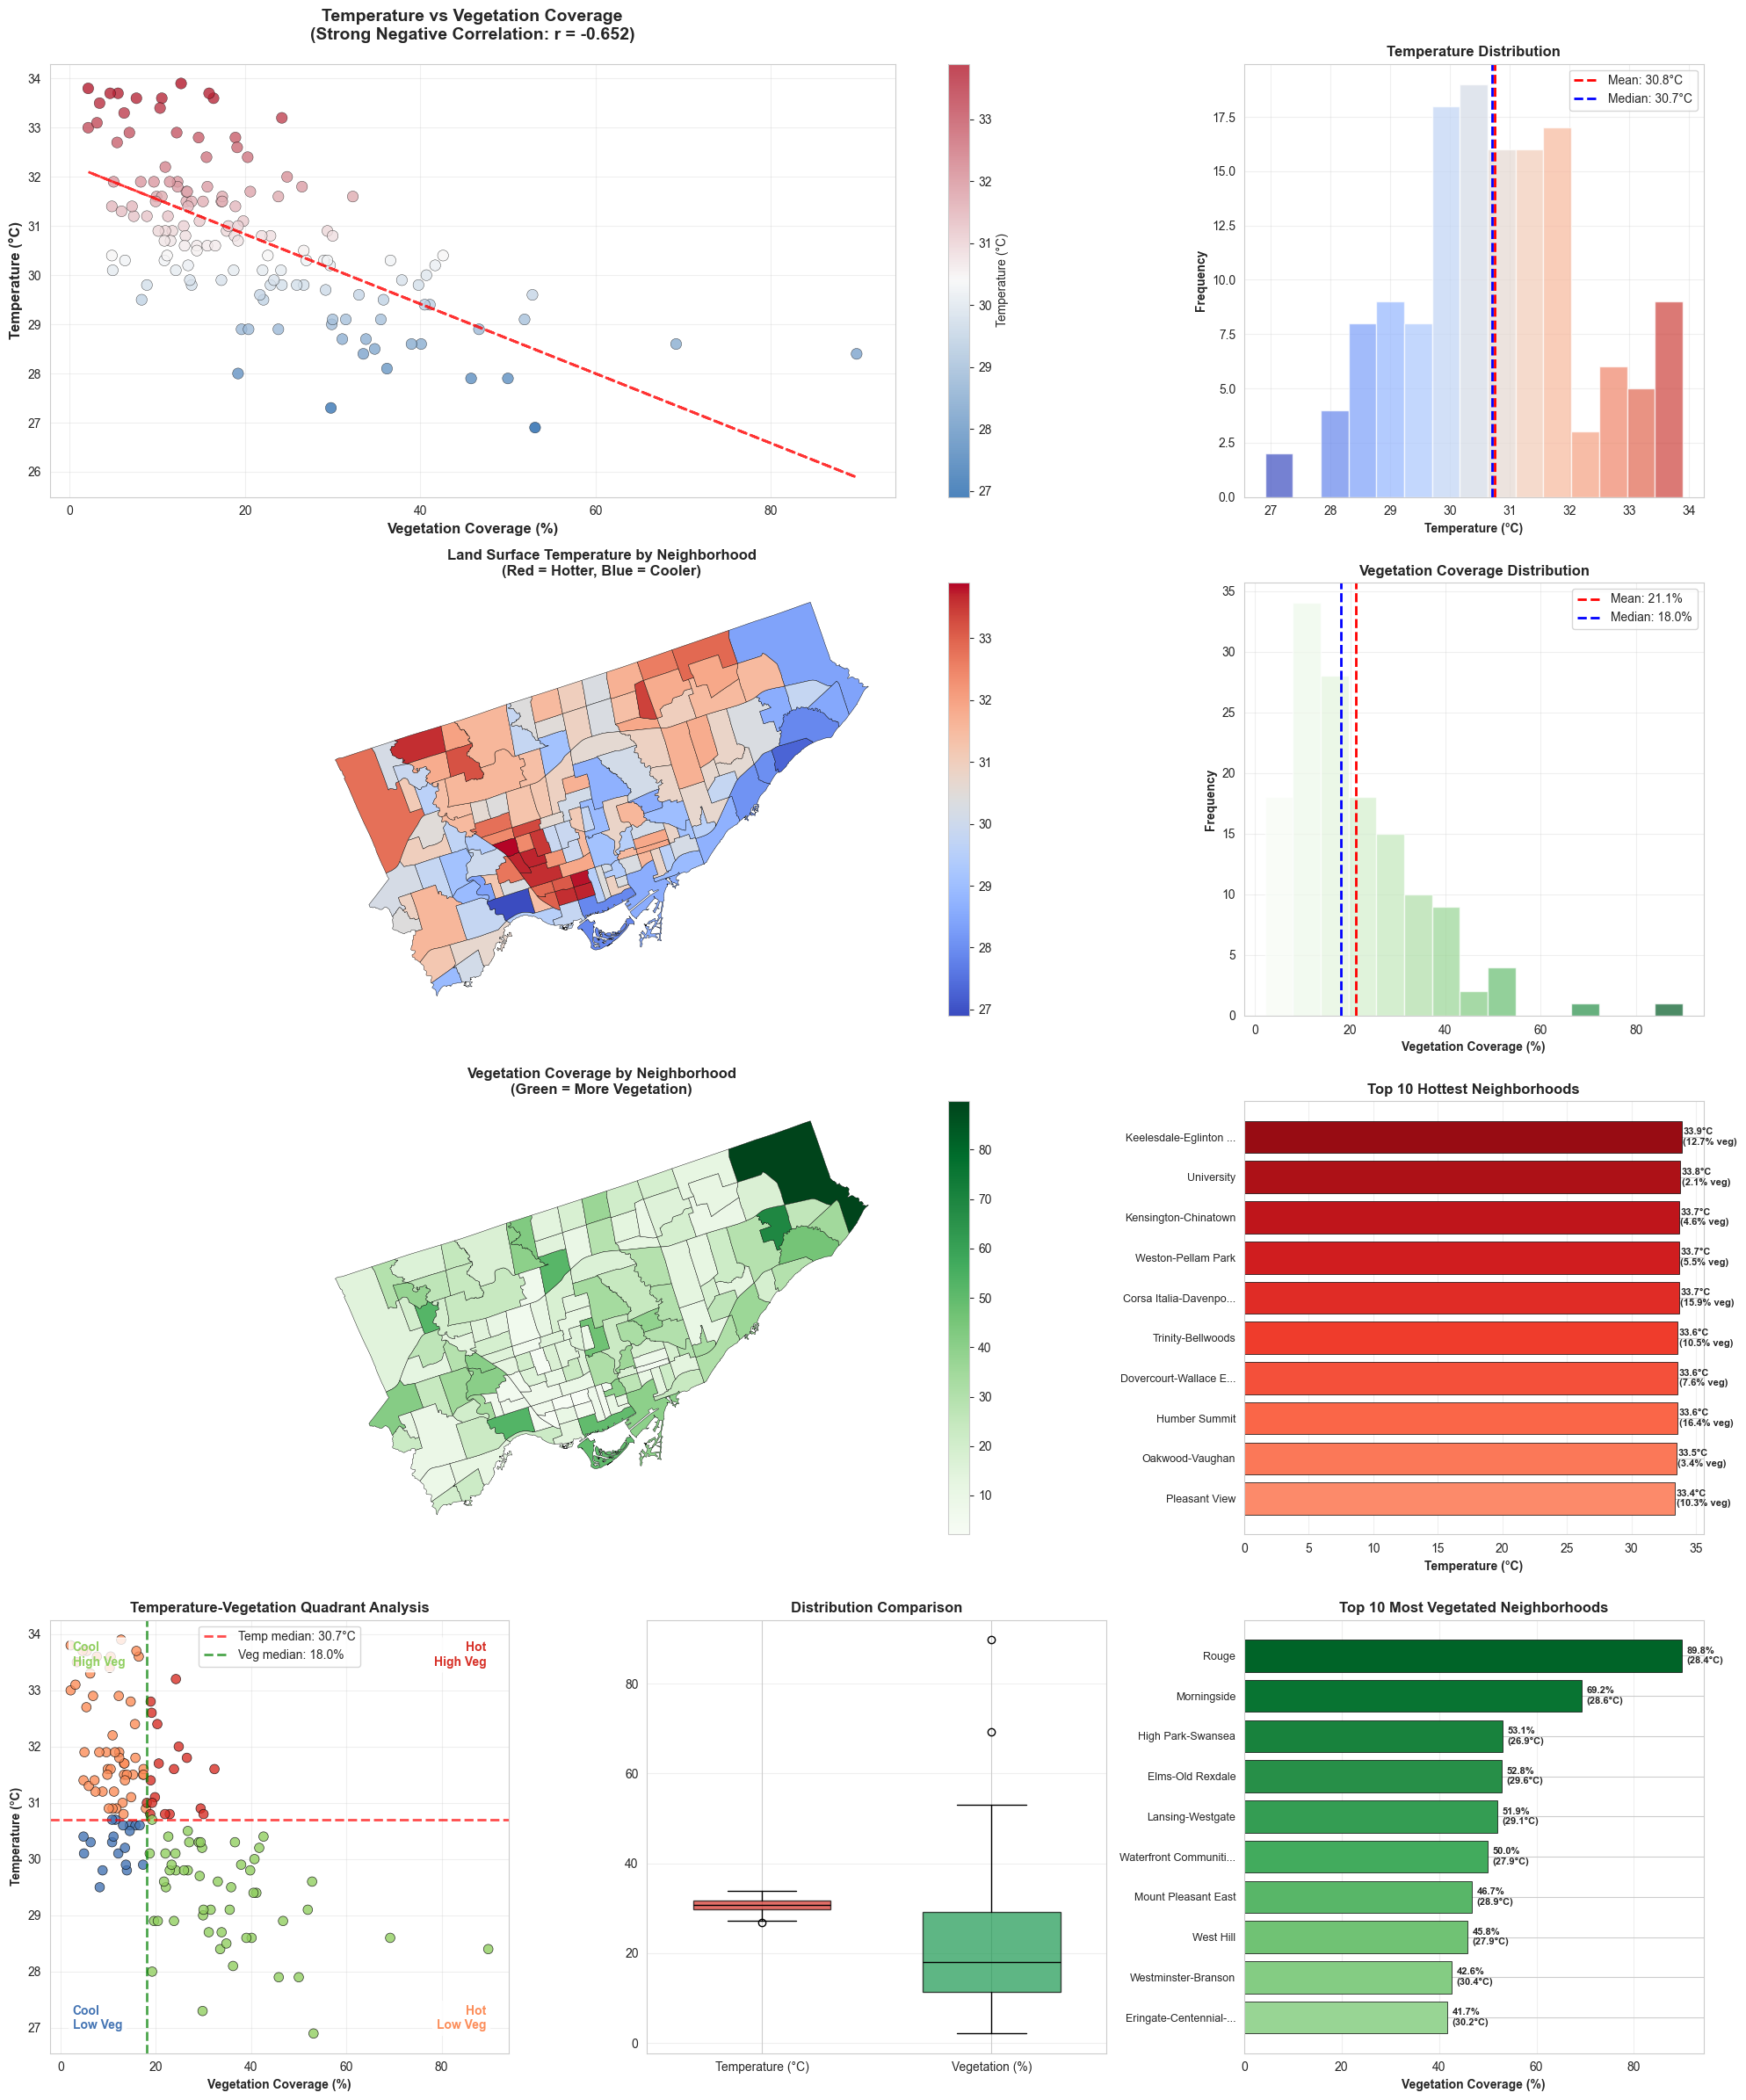


COMPREHENSIVE DATA SUMMARY
Total Neighborhoods Analyzed: 140
Temperature Statistics:
   • Mean: 30.8°C
   • Median: 30.7°C
   • Range: 26.9°C to 33.9°C
   • Standard Deviation: 1.5°C
Vegetation Statistics:
   • Mean: 21.1%
   • Median: 18.0%
   • Range: 2.1% to 89.8%
   • Standard Deviation: 13.9%
Correlation Analysis:
   • Pearson r: -0.652 (Strong Negative Correlation)
   • P-value: 0.000000 (Highly Significant)

Key Insights:
Hottest Area: Keelesdale-Eglinton West (33.9°C, 12.7% vegetation)
Coolest Area: High Park-Swansea (26.9°C, 53.1% vegetation)
Most Vegetated: Rouge (89.8% vegetation, 28.4°C)
Least Vegetated: Little Portugal (2.1% vegetation, 33.0°C)


In [ ]:
#Step 10: More visualization
print("=== COMPREHENSIVE DATA VISUALIZATION - LIGHT THEME ===")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap

# Set up the style 
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette("viridis")

# Create custom color schemes
temp_cmap = LinearSegmentedColormap.from_list('temp_cmap', ['#2166ac', '#f7f7f7', '#b2182b'])
veg_cmap = LinearSegmentedColormap.from_list('veg_cmap', ['#f7f7f7', '#67a9cf', '#01665e'])

fig = plt.figure(figsize=(20, 24))
fig.patch.set_facecolor('white')

# 1. Main Scatter Plot with Trend Line
ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=2)
scatter = ax1.scatter(final_data['greenspace_pct'], final_data['lst_mean'], 
                     c=final_data['lst_mean'], cmap=temp_cmap, s=80, alpha=0.8, 
                     edgecolors='black', linewidth=0.3)
ax1.set_xlabel('Vegetation Coverage (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Temperature (°C)', fontsize=12, fontweight='bold')
ax1.set_title('Temperature vs Vegetation Coverage\n(Strong Negative Correlation: r = {:.3f})'.format(correlation), 
             fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(final_data['greenspace_pct'], final_data['lst_mean'], 1)
p = np.poly1d(z)
ax1.plot(final_data['greenspace_pct'], p(final_data['greenspace_pct']), 
        "r--", alpha=0.8, linewidth=2, label='Trend line')

plt.colorbar(scatter, ax=ax1, label='Temperature (°C)')

# 2. Temperature Distribution
ax2 = plt.subplot2grid((4, 3), (0, 2))
temp_data = final_data['lst_mean']
n, bins, patches = ax2.hist(temp_data, bins=15, color='#d73027', alpha=0.7, edgecolor='white')

# Color bars by temperature
for i, (patch, bin_val) in enumerate(zip(patches, bins)):
    patch.set_facecolor(plt.cm.coolwarm((bin_val - temp_data.min()) / (temp_data.max() - temp_data.min())))

ax2.axvline(temp_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {temp_data.mean():.1f}°C')
ax2.axvline(temp_data.median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {temp_data.median():.1f}°C')
ax2.set_xlabel('Temperature (°C)', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Temperature Distribution', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Vegetation Distribution
ax3 = plt.subplot2grid((4, 3), (1, 2))
veg_data = final_data['greenspace_pct']
n, bins, patches = ax3.hist(veg_data, bins=15, color='#1a9850', alpha=0.7, edgecolor='white')

# Color bars by vegetation percentage
for i, (patch, bin_val) in enumerate(zip(patches, bins)):
    patch.set_facecolor(plt.cm.Greens((bin_val - veg_data.min()) / (veg_data.max() - veg_data.min())))

ax3.axvline(veg_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {veg_data.mean():.1f}%')
ax3.axvline(veg_data.median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {veg_data.median():.1f}%')
ax3.set_xlabel('Vegetation Coverage (%)', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('Vegetation Coverage Distribution', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Temperature Map
ax4 = plt.subplot2grid((4, 3), (1, 0), colspan=2)
final_data.plot(column='lst_mean', ax=ax4, cmap='coolwarm', legend=True, 
               edgecolor='black', linewidth=0.3)
ax4.set_title('Land Surface Temperature by Neighborhood\n(Red = Hotter, Blue = Cooler)', 
             fontweight='bold')
ax4.set_axis_off()

# 5. Vegetation Map
ax5 = plt.subplot2grid((4, 3), (2, 0), colspan=2)
final_data.plot(column='greenspace_pct', ax=ax5, cmap='Greens', legend=True,
               edgecolor='black', linewidth=0.3)
ax5.set_title('Vegetation Coverage by Neighborhood\n(Green = More Vegetation)', 
             fontweight='bold')
ax5.set_axis_off()

# 6. Top 10 Hottest Neighborhoods
ax6 = plt.subplot2grid((4, 3), (2, 2))
hottest = final_data.nlargest(10, 'lst_mean')[['HOOD', 'lst_mean', 'greenspace_pct']]
hottest_sorted = hottest.sort_values('lst_mean', ascending=True)
y_pos = np.arange(len(hottest_sorted))

colors_hot = plt.cm.Reds(np.linspace(0.4, 0.9, 10))
bars = ax6.barh(y_pos, hottest_sorted['lst_mean'], color=colors_hot, edgecolor='black', linewidth=0.5)

ax6.set_yticks(y_pos)
ax6.set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in hottest_sorted['HOOD']], fontsize=9)
ax6.set_xlabel('Temperature (°C)', fontweight='bold')
ax6.set_title('Top 10 Hottest Neighborhoods', fontweight='bold')
ax6.grid(True, alpha=0.3, axis='x')

# Add temperature values on bars
for i, (bar, temp, veg) in enumerate(zip(bars, hottest_sorted['lst_mean'], hottest_sorted['greenspace_pct'])):
    ax6.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
            f'{temp:.1f}°C\n({veg:.1f}% veg)', 
            ha='left', va='center', fontsize=8, fontweight='bold')

# 7. Top 10 Most Vegetated Neighborhoods
ax7 = plt.subplot2grid((4, 3), (3, 2))
most_veg = final_data.nlargest(10, 'greenspace_pct')[['HOOD', 'greenspace_pct', 'lst_mean']]
most_veg_sorted = most_veg.sort_values('greenspace_pct', ascending=True)
y_pos = np.arange(len(most_veg_sorted))

colors_veg = plt.cm.Greens(np.linspace(0.4, 0.9, 10))
bars = ax7.barh(y_pos, most_veg_sorted['greenspace_pct'], color=colors_veg, edgecolor='black', linewidth=0.5)

ax7.set_yticks(y_pos)
ax7.set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in most_veg_sorted['HOOD']], fontsize=9)
ax7.set_xlabel('Vegetation Coverage (%)', fontweight='bold')
ax7.set_title('Top 10 Most Vegetated Neighborhoods', fontweight='bold')
ax7.grid(True, alpha=0.3, axis='x')

# Add vegetation values on bars
for i, (bar, veg, temp) in enumerate(zip(bars, most_veg_sorted['greenspace_pct'], most_veg_sorted['lst_mean'])):
    ax7.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
            f'{veg:.1f}%\n({temp:.1f}°C)', 
            ha='left', va='center', fontsize=8, fontweight='bold')

# 8. Temperature-Vegetation Quadrant Analysis
ax8 = plt.subplot2grid((4, 3), (3, 0))
temp_median = final_data['lst_mean'].median()
veg_median = final_data['greenspace_pct'].median()

# Create quadrant colors
colors = []
for i, row in final_data.iterrows():
    if row['lst_mean'] > temp_median and row['greenspace_pct'] > veg_median:
        colors.append('#d73027')  # Hot, High Veg - Red
    elif row['lst_mean'] > temp_median and row['greenspace_pct'] <= veg_median:
        colors.append('#fc8d59')  # Hot, Low Veg - Orange
    elif row['lst_mean'] <= temp_median and row['greenspace_pct'] > veg_median:
        colors.append('#91cf60')  # Cool, High Veg - Green
    else:
        colors.append('#4575b4')  # Cool, Low Veg - Blue

scatter = ax8.scatter(final_data['greenspace_pct'], final_data['lst_mean'], 
                     c=colors, s=60, alpha=0.8, edgecolors='black', linewidth=0.5)
ax8.axhline(temp_median, color='red', linestyle='--', alpha=0.7, linewidth=2, 
           label=f'Temp median: {temp_median:.1f}°C')
ax8.axvline(veg_median, color='green', linestyle='--', alpha=0.7, linewidth=2, 
           label=f'Veg median: {veg_median:.1f}%')
ax8.set_xlabel('Vegetation Coverage (%)', fontweight='bold')
ax8.set_ylabel('Temperature (°C)', fontweight='bold')
ax8.set_title('Temperature-Vegetation Quadrant Analysis', fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3)

# Add quadrant labels
ax8.text(0.95, 0.95, 'Hot\nHigh Veg', transform=ax8.transAxes, ha='right', va='top', 
        fontweight='bold', fontsize=10, color='#d73027', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
ax8.text(0.95, 0.05, 'Hot\nLow Veg', transform=ax8.transAxes, ha='right', va='bottom', 
        fontweight='bold', fontsize=10, color='#fc8d59', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
ax8.text(0.05, 0.95, 'Cool\nHigh Veg', transform=ax8.transAxes, ha='left', va='top', 
        fontweight='bold', fontsize=10, color='#91cf60', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
ax8.text(0.05, 0.05, 'Cool\nLow Veg', transform=ax8.transAxes, ha='left', va='bottom', 
        fontweight='bold', fontsize=10, color='#4575b4', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# 9. Box Plots Comparison
ax9 = plt.subplot2grid((4, 3), (3, 1))
box_data = [final_data['lst_mean'], final_data['greenspace_pct']]
box_labels = ['Temperature (°C)', 'Vegetation (%)']
box_colors = ['#d73027', '#1a9850']

box_plot = ax9.boxplot(box_data, labels=box_labels, patch_artist=True, widths=0.6)
for patch, color in zip(box_plot['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

for element in ['whiskers', 'caps', 'medians']:
    plt.setp(box_plot[element], color='black')

ax9.set_title('Distribution Comparison', fontweight='bold')
ax9.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Additional Summary Statistics
print("\n" + "="*60)
print("COMPREHENSIVE DATA SUMMARY")
print("="*60)
print(f"Total Neighborhoods Analyzed: {len(final_data)}")
print(f"Temperature Statistics:")
print(f"   • Mean: {final_data['lst_mean'].mean():.1f}°C")
print(f"   • Median: {final_data['lst_mean'].median():.1f}°C") 
print(f"   • Range: {final_data['lst_mean'].min():.1f}°C to {final_data['lst_mean'].max():.1f}°C")
print(f"   • Standard Deviation: {final_data['lst_mean'].std():.1f}°C")
print(f"Vegetation Statistics:")
print(f"   • Mean: {final_data['greenspace_pct'].mean():.1f}%")
print(f"   • Median: {final_data['greenspace_pct'].median():.1f}%")
print(f"   • Range: {final_data['greenspace_pct'].min():.1f}% to {final_data['greenspace_pct'].max():.1f}%")
print(f"   • Standard Deviation: {final_data['greenspace_pct'].std():.1f}%")
print(f"Correlation Analysis:")
print(f"   • Pearson r: {correlation:.3f} (Strong Negative Correlation)")
print(f"   • P-value: {p_value:.6f} (Highly Significant)")

# Show key insights
hottest = final_data.nlargest(1, 'lst_mean').iloc[0]
coolest = final_data.nsmallest(1, 'lst_mean').iloc[0]
most_veg = final_data.nlargest(1, 'greenspace_pct').iloc[0]
least_veg = final_data.nsmallest(1, 'greenspace_pct').iloc[0]

print(f"\nKey Insights:")
print(f"Hottest Area: {hottest['HOOD']} ({hottest['lst_mean']:.1f}°C, {hottest['greenspace_pct']:.1f}% vegetation)")
print(f"Coolest Area: {coolest['HOOD']} ({coolest['lst_mean']:.1f}°C, {coolest['greenspace_pct']:.1f}% vegetation)")
print(f"Most Vegetated: {most_veg['HOOD']} ({most_veg['greenspace_pct']:.1f}% vegetation, {most_veg['lst_mean']:.1f}°C)")
print(f"Least Vegetated: {least_veg['HOOD']} ({least_veg['greenspace_pct']:.1f}% vegetation, {least_veg['lst_mean']:.1f}°C)")